In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import skimage.io
import glob

import os
import io
from PIL import Image
Image.MAX_IMAGE_PIXELS = 50000000000

import tqdm

from albumentations import *
import albumentations.augmentations.functional as F

import sys
sys.path.append('..')
from config import Config
from util import DataManager 

tf.config.set_visible_devices([], 'GPU')

Path to images:  ../../../input/prostate-cancer-grade-assessment/train_images/
Image tiff-format:  False


In [91]:
@tf.function
def read_image(image_path, label):
    
    image = tf.io.read_file(image_path + '.jpeg')
    if tf.strings.length(image) > 6_500_000:
        tf.print("Image too big, will be downscaled")
        image = tf.image.decode_jpeg(image, channels=3, ratio=2)
    else:
        image = image = tf.image.decode_jpeg(image, channels=3)
    return image, label

dataframe = DataManager.get_train_data()
dataframe = dataframe

image_paths = ('../../../input/prostate-cancer-grade-assessment/train_images/' + dataframe.image_id).values.astype(str)
labels = np.zeros((len(dataframe), 5), dtype=np.int32)
for i, label in enumerate(dataframe.isup_grade):
    labels[i, :label] = 1.

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(read_image, tf.data.experimental.AUTOTUNE)

In [92]:
for _ in tqdm.tqdm(dataset):
    pass

 56%|█████▋    | 5992/10616 [00:49<00:31, 146.74it/s]

image too big


 62%|██████▏   | 6604/10616 [00:53<00:32, 122.09it/s]

image too big


 64%|██████▍   | 6829/10616 [00:55<00:29, 129.89it/s]

image too big


100%|██████████| 10616/10616 [01:25<00:00, 124.14it/s]


In [80]:
im, _ = read_image(
        '../../../input/prostate-cancer-grade-assessment/train_images/' + dataframe.image_id.iloc[14], None)

In [81]:
im.shape

TensorShape([4776, 11876, 3])

In [73]:
len(im.numpy())

1241495

In [37]:
for x in tqdm.tqdm(dataset):
    pass

100%|██████████| 4616/4616 [00:08<00:00, 567.69it/s]


In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import skimage.io
import glob
import os
import io
from PIL import Image
Image.MAX_IMAGE_PIXELS = 5000000000

from albumentations import *
import albumentations.augmentations.functional as F


from config import Config

def map_decorator(func):
    def wrapper(*args):
        return tf.py_function(
            func=func,
            inp=[*args],
            Tout=[tf.uint8, tf.int32]
        )
    return wrapper

augmentor = (
    Compose([
      # OneOf([
      #   ShiftScaleRotate(
      #       shift_limit=0.0625,
      #       scale_limit=0.1,
      #       rotate_limit=90,
      #       p=0.5),
      #   ElasticTransform(
      #       alpha=601,
      #       sigma=25,
      #       alpha_affine=10,
      #       p=0.5),
      #   GridDistortion(
      #       num_steps=3,
      #       distort_limit=0.5,
      #       p=0.5),
      #   NoOp()
      # ]),
      # OneOf([
      #   RandomBrightnessContrast(
      #       brightness_limit=0.15,
      #       contrast_limit=0.15,
      #       p=0.5),
      #   RandomGamma(
      #       gamma_limit=(85, 115),
      #       p=0.5),
      #   NoOp()
      # ]),
      # OneOf([
      #   RGBShift(
      #       r_shift_limit=(-15, 15),
      #       g_shift_limit=(-15, 15),
      #       b_shift_limit=(-15, 15),
      #       p=0.5),
      #   HueSaturationValue(
      #       hue_shift_limit=(-15, 15),
      #       sat_shift_limit=(-25, 25),
      #       val_shift_limit=(-15, 15),
      #       p=0.5),
      #   NoOp()
      # ]),
      RandomRotate90(
          p=0.5),
      Flip(
          p=0.5),
      Transpose(
          p=0.5),
   ])
)

@map_decorator
def augmentation(image, label):
    image = augmentor(image=image.numpy())['image']
    return image, label

@map_decorator
def jpeg_compression(image, label):
    buffer = io.BytesIO()
    Image.fromarray(image.numpy()).save(buffer, format='jpeg', quality=90)
    image = np.array(Image.open(buffer))
    return image, label#F.image_compression(image, quality=90, image_type='.jpg')

if Config.input.tiff_format:

    def _crop_white(image):
        value = 255
        assert image.shape[2] == 3
        assert image.dtype == np.uint8
        ys, = (image.min((1, 2)) < value).nonzero()
        xs, = (image.min(0).min(1) < value).nonzero()
        if len(xs) == 0 or len(ys) == 0:
            return image
        image = image[ys.min():ys.max() + 1, xs.min():xs.max() + 1]
        del ys
        del xs
        return image

    @map_decorator
    def read_image(image_path, label, level=Config.input.tiff_level, resize_ratio=Config.input.resize_ratio):
        image_path = image_path.numpy().decode('utf-8')
        image = skimage.io.MultiImage(image_path + '.tiff')
        image = image[level]
        image = _crop_white(image)
        if resize_ratio != 1:
            new_w = int(image.shape[1]*resize_ratio)
            new_h = int(image.shape[0]*resize_ratio)
            image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return image, label
else:
    @map_decorator
    def read_image(image_path, label, resize_ratio=Config.input.resize_ratio):
        image_path = image_path.numpy().decode('utf-8')
        # image = cv2.imread(image_path + '.jpeg')
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(image_path + '.jpeg')
        image = np.array(image)
        if resize_ratio != 1:
            new_w = int(image.shape[1]*resize_ratio)
            new_h = int(image.shape[0]*resize_ratio)
            image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return image, label

@tf.function
def compute_patches(image, label, ps=Config.input.patch_size, ss=Config.input.sample_size):
    """Computes patches to be used as input to the Neural Network.
    If number of patches exceeds the sample_size (ss), the
    patches with most information are selected"""
    image_shape = tf.shape(image)
    h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)
    pad_h = (ps - h % ps)
    pad_w = (ps - w % ps)

    pu = tf.random.uniform(shape=(), minval=0, maxval=pad_h, dtype=tf.int32)
    pd = pad_h - pu
    pl = tf.random.uniform(shape=(), minval=0, maxval=pad_w, dtype=tf.int32)
    pr = pad_w - pl

    image = tf.pad(
        image, ((pu, pd), (pl, pr), (0, 0)), constant_values=255)

    image_shape = tf.shape(image)
    h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)

    image = tf.reshape(image, (h//ps, ps, w//ps, ps, 3))
    image = tf.transpose(image, (0, 2, 1, 3, 4))
    image = tf.reshape(image, (-1, ps, ps, 3))

    num_images = tf.gather(tf.shape(image), 0)

    info = tf.reduce_sum(tf.cast(tf.reshape(image, (num_images, -1)), tf.int32), 1)

    if tf.gather(tf.shape(info), 0) < ss:

        image = tf.pad(
            image, ((0, ss-num_images), (0, 0), (0, 0), (0, 0)), constant_values=255)

        paddings = tf.zeros(ss-num_images, dtype=tf.int32)+(ps**2*3*255)
        info = tf.concat((info, paddings), axis=0)

    indices = tf.gather(tf.argsort(info), tf.range(ss))
    image = tf.gather(image, indices)
    return image, label

def _patch_augment(patch):
    """Performs random rotation, random flip (u/d, l/r),
    and random transpose, based on probability p"""
    p = 0.5
    r1 = tf.random.uniform(
        shape=(4,), minval=0, maxval=1)
    r2 = tf.random.uniform(
        shape=(), minval=0, maxval=4, dtype=tf.int32)
    if r1[0] > (1-p):
        patch = tf.image.rot90(patch, k=r2)
    if r1[1] > (1-p):
        patch = tf.image.random_flip_left_right(patch)
    if r1[2] > (1-p):
        patch = tf.image.random_flip_up_down(patch)
    if r1[3] > (1-p):
        patch = tf.transpose(patch, (1, 0, 2))
    return patch

@tf.function
def stitch_patches(patches, label, ps=Config.input.patch_size, l=int(np.sqrt(Config.input.sample_size))):
    """Stitches together patches into one single
    big image, with augmentation on patch-level"""
    image = tf.zeros([0, ps, ps, 3], dtype=tf.uint8)
    #patches = tf.random.shuffle(patches) # TESTING
    for i in range(len(patches)):
        _patch = _patch_augment(tf.gather(patches, i))
        image = tf.concat((
            image, tf.expand_dims(_patch, 0)
        ), axis=0)
    image = tf.reshape(image, (-1, ps*l, ps, 3))
    image = tf.transpose(image, (0, 2, 1, 3))
    image = tf.reshape(image, (ps*l, ps*l, 3))
    return image, label

@tf.function
def preprocess_input(x, y, mode=Config.input.preprocess_mode):
    x = tf.cast(x, dtype=tf.dtypes.float32)
    y = tf.cast(y, dtype=tf.dtypes.float32)
    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x, y
    elif mode == 'torch':
        x /= 255.
        mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
        std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
        x -= mean
        x /= std
        return x, y
    elif mode == 'caffe':
        mean = tf.constant([103.939, 116.779, 123.68], dtype=tf.float32)
        x -= mean
        return x, y
    elif mode == 'float':
        x /= 255.
        return x, y
    else:
        return x, y

def get_dataset(dataframe,
                input_path,
                batch_size,
                training,
                augment,
                tta=1,
                input_size=(1536, 1536, 3),
                buffer_size=1,
                cache=False):


    def nested_stiching(x, y):
        return (
            tf.data.Dataset.from_tensor_slices((x, y))
            .map(stitch_patches, tf.data.experimental.AUTOTUNE)
            .map(augmentation, tf.data.experimental.AUTOTUNE)
            .batch(tta)
        )

    if cache:
        if not(os.path.isdir('../tmp/')):
            os.mkdir('../tmp')
        else:
            files = glob.glob(f'../tmp/*')
            for f in files:
                os.remove(f)
        if training:
            cache_path = '../tmp/cache_train'
        else:
            cache_path = '../tmp/cache_infer'

    image_paths = (input_path + dataframe.image_id).values.astype(str)
    labels = np.zeros((len(dataframe), 5), dtype=np.int32)
    for i, label in enumerate(dataframe.isup_grade):
        labels[i, :label] = 1.

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(read_image, tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(compute_patches, tf.data.experimental.AUTOTUNE)

    if cache:
        dataset = dataset.cache(cache_path)
            
    if tta > 1:
        dataset = dataset.map(
            lambda x, y: (
                tf.tile(tf.expand_dims(x, 0), (tta, 1, 1, 1, 1)),
                tf.tile(tf.expand_dims(y, 0), (tta, 1))))
        
        dataset = dataset.flat_map(nested_stiching)
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(
            lambda x, y: (
                tf.reshape(x, (-1, *input_size)),
                tf.reshape(y, (-1, 5))))
    else:
        dataset = dataset.map(stitch_patches, tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.map(augmentation, tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
            
    dataset = dataset.map(preprocess_input, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [7]:
dataframe = DataManager.get_train_data()
input_path = DataManager.get_path() + 'train_images/'

In [11]:
dataset = get_dataset(
    dataframe.iloc[:13],
    Config.input.path,
    batch_size=Config.train.batch_size,
    training=False,
    augment=False,
    tta=4,
    input_size=Config.input.input_shape,
    buffer_size=1,
    cache=True,
)


In [12]:
for x, y in tqdm.tqdm(dataset):
    pass
    

7it [00:08,  1.27s/it]


In [13]:
x.numpy().shape

(4, 1536, 1536, 3)

In [26]:
for x, y in tqdm.tqdm(dataset.take(160)):
    pass
    

100%|██████████| 160/160 [01:04<00:00,  2.48it/s]


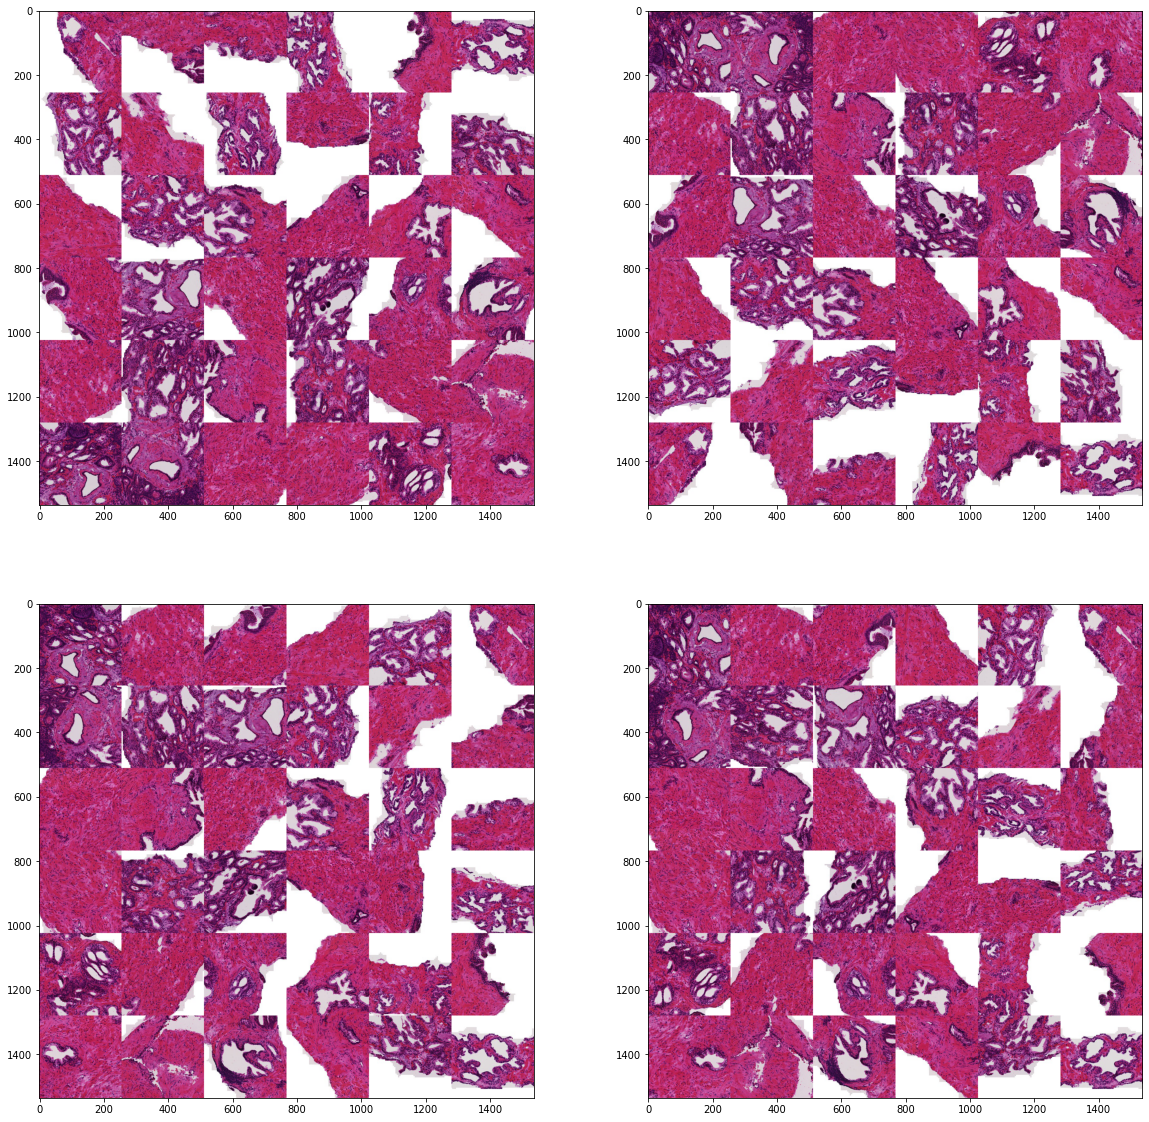

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, ax in enumerate(axes.reshape(-1)):
    
    ax.imshow(x.numpy()[i+4])

In [33]:
img = x[0]

In [48]:
tf.tile(tf.expand_dims(img, 0), [2, 1, 1, 1])

<tf.Tensor: shape=(2, 1536, 1536, 3), dtype=uint8, numpy=
array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [230, 219, 219],
         [219, 219, 235],
         [235, 235, 235]],

        [[195, 195, 195],
         [195, 185, 185],
         [185, 185, 196],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[204, 204, 204],
         [204, 177, 177],
         [177, 177, 196],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[233, 233, 233],
         [233, 162, 162],
         [162, 162, 206],
         ...,
         [244, 250, 250],
         [250, 250, 248],
         [248, 248, 248]],

        [[203, 203, 203],
         [203, 162, 162],
         [162, 162, 202],
         ...,
         [184, 141, 141],
         [141, 141, 184],
         [184, 184, 184]],

        [[178, 178, 178],
         [178, 139, 139],
         [139, 1